# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import joblib
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
# Load data from pre-saved pickle files for faster 
general = pd.read_csv('../data/Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv')

C:\Users\ADMIN\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(f'{general.shape}')
general.head()

(891221, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,TYPE
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,general
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,general
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,general
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,general
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,general


In [4]:
print(f'{customers.shape}')
customers.head()

(191652, 370)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,TYPE
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4,customer
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4,customer
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4,customer
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4,customer
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3,customer


In [5]:
# extra columns in customers
set(customers.columns) - set(general.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [6]:
# investigate the three extra columns: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD


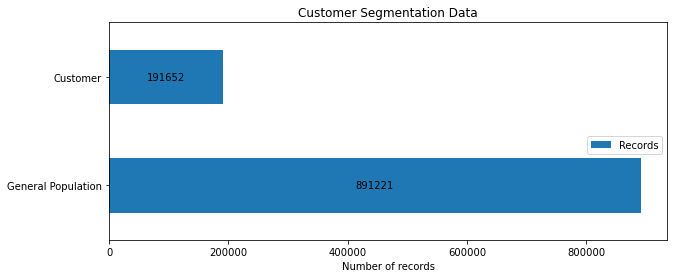

In [7]:
df_summary = pd.DataFrame(np.array([general.shape[0], customers.shape[0]]), index=['General Population', 'Customer'], columns=['Records'])
plot1 = df_summary
ax = plot1.plot.barh(figsize=(10, 4))
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.title('Customer Segmentation Data')
plt.xlabel('Number of records')

# annotations:
for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
plt.savefig('../images/customer_segmentation_data.png', dpi=500)

### merge the two datasets

since the overall population is made up of both `general` and `customers`, for general preprocessing techniques and exploration, it's would be more generalized to work on the merge data of common features between the two sets

In [8]:
df = pd.concat([general, customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])])

In [9]:
print(f'{df.shape}')
df.head()

(1082873, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,TYPE
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,general
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,general
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,general
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4,general
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,general


### clean data

Columns (18,19) have mixed types, we'll fixed it by replacing the string value of 'X' and 'XX' as missing value, and set datatype as float

In [10]:
# fix the mixed datatype message

# check which columns having mixed datatype
COLUMNS_WITH_MIXED_TYPES = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']

# replace the outline 'X' and 'XX' value with nan
def format_mixed_types(df, cols_mixed_types=COLUMNS_WITH_MIXED_TYPES):
    '''This function is created for formating improper
    values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.
    Args:
    df: demographics dataframe
    returns: transformed dataframe
    '''

    if set(cols_mixed_types).issubset(df.columns):
        for col in cols_mixed_types:
            print(col)
            df[col] = df[col].replace({'X': np.nan, 'XX': np.nan})
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                continue
            print(df[col].unique())

    return df

df = format_mixed_types(df)

CAMEO_DEUG_2015
[nan  8.  4.  2.  6.  1.  9.  5.  7.  3.]
CAMEO_INTL_2015
[nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.]
CAMEO_DEU_2015


In [11]:
# drop duplicate
(nrow, ncol) = df.shape
df.drop_duplicates(keep='last', inplace=True)
print(f'Drop {df.shape[0]-nrow} duplicated rows, Number of rows after drop: {df.shape[0]}')

Drop 0 duplicated rows, Number of rows after drop: 1082873


In [12]:
# missing rates of columns
missing = df.isnull().sum().sort_values(ascending=False) / nrow

Text(0, 0.5, 'number of columns')

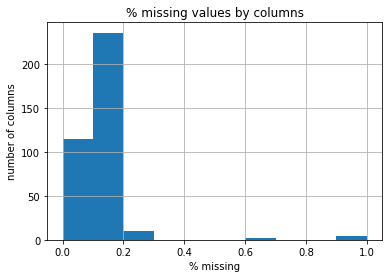

In [13]:
# plot histogram of missing values by columns
missing_cols_hist = missing.hist()
# set title and axis labels
missing_cols_hist.set_title('% missing values by columns')
missing_cols_hist.set_xlabel('% missing')
missing_cols_hist.set_ylabel("number of columns")
# missing_cols_hist.figure.savefig('missing_cols_hist.png', dpi=500)

Most columns have 20% or less values missing. It's reasonable to choose 20% as threshold to drop the columns

In [14]:
cols_missing_20pect = list(missing[missing>0.2].index)
print(f'There are {len(cols_missing_20pect)} columns with more than 20% values missing, /n'
      f'  {round(len(cols_missing_20pect)/ncol,2)*100}% of total columns')
print(f'Cols to drop: {cols_missing_20pect}')

There are 16 columns with more than 20% values missing, /n  4.0% of total columns
Cols to drop: ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP', 'ALTERSKATEGORIE_FEIN', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_LOTTO', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12']


In [15]:
# missing values by row
missing_rows = df.isnull().sum(axis=1)

Text(0, 0.5, 'number of rows')

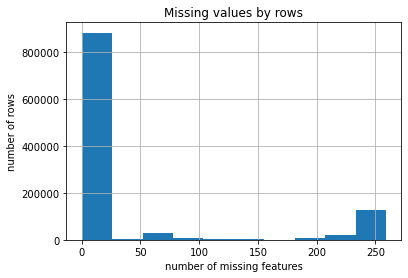

In [16]:
# plot histogram of missing values by row
missing_rows_hist = missing_rows.hist()
# set title and axis labels
missing_rows_hist.set_title('Missing values by rows')
missing_rows_hist.set_xlabel('number of missing features')
missing_rows_hist.set_ylabel("number of rows")
# missing_rows_hist.figure.savefig('missing_rows_hist.png', dpi=500)

In [17]:
missing_rows.describe().apply(lambda x: format(x, 'f'))

count    1082873.000000
mean          43.734530
std           83.008508
min            0.000000
25%            5.000000
50%            6.000000
75%           16.000000
max          259.000000
dtype: object

In [19]:
drop_missing_rows = list(missing_rows[missing_rows > 84].index)
print(f'There are {len(missing_rows)} rows with more than 84 attributes missing, /n'
      f'  {round(len(missing_rows)/nrow,2)*100}% of total rows')

There are 1082873 rows with more than 84 attributes missing, /n  100.0% of total rows


In [20]:
# find columns with identifier or columns with one value with more than 95% of total population

def identifier_to_drop(df):
    nrow = df.shape[0]
    cols_to_drop = []

    for col in df.columns:
        # check if column has more than 95% of values are uniques
        nunique_rate = df[col].nunique() / nrow
        if nunique_rate > 0.95:
            cols_to_drop.append(col)
            print(f'{col} has {round(nunique_rate, 2) * 100}% values are unique')

        # check if column has more than 95% of values belongs to only 1 categories
        mode_count = df[col].value_counts().values[0]
        mode_freq = mode_count / nrow
        if mode_freq > 0.95:
            cols_to_drop.append(col)
            print(f'{col} has {round(mode_freq, 2) * 100}% values belongs to categoy {df[col].value_counts().index[0]}')

    return cols_to_drop

drop_identifier_cols = identifier_to_drop(df)
print(f'There are {len(drop_identifier_cols)} columns with identifier or columns with one value with more than '
      f'95% of total population')

LNR has 100.0% values are unique
D19_BANKEN_LOKAL has 98.0% values belongs to categoy 0
D19_BANKEN_OFFLINE_DATUM has 97.0% values belongs to categoy 10
D19_DIGIT_SERV has 96.0% values belongs to categoy 0
D19_GARTEN has 95.0% values belongs to categoy 0
D19_TELKO_ANZ_12 has 96.0% values belongs to categoy 0
D19_TELKO_ONLINE_DATUM has 99.0% values belongs to categoy 10
D19_TIERARTIKEL has 96.0% values belongs to categoy 0
D19_VERSI_OFFLINE_DATUM has 96.0% values belongs to categoy 10
D19_VERSI_ONLINE_DATUM has 99.0% values belongs to categoy 10
There are 10 columns with identifier or columns with one value with more than 95% of total population


In [21]:
# append to drop cols
drop_cols = list(set(cols_missing_20pect + drop_identifier_cols))
print("{} columns will be dropped from the dataset: {}".format(len(drop_cols), drop_cols))

# drop collection of columns
df.drop(columns=drop_cols, inplace=True)
print(f'Dropped {df.shape[1] - ncol} columns, Number of columns after drop: {df.shape[1]}')

26 columns will be dropped from the dataset: ['D19_GARTEN', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_LOTTO', 'D19_KONSUMTYP', 'LNR', 'D19_TIERARTIKEL', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2', 'ALTERSKATEGORIE_FEIN', 'D19_TELKO_ANZ_12', 'ALTER_KIND3', 'D19_VERSI_OFFLINE_DATUM', 'KK_KUNDENTYP', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EXTSEL992', 'ALTER_KIND1', 'D19_DIGIT_SERV', 'D19_SOZIALES', 'D19_LETZTER_KAUF_BRANCHE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_BANKEN_LOKAL', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND4']
Dropped -26 columns, Number of columns after drop: 341


In [22]:
# drop missing rows
nrow = df.shape[0]
df.drop(labels=drop_missing_rows, axis=0, inplace=True)
print(f'Dropped {nrow - df.shape[0]} rows, Number of rows after drop: {df.shape[0]}')

Dropped 220120 rows, Number of rows after drop: 862753


In [23]:
# deal with attributes with values as string
# transform datetime variable into Year and Month, + drop variables with too many values
def clean_categorical(df, cols_drop = []):
    '''This function deals designated columns and imputes missing data.
    Args:
    df: demographic dataframe
    returns: none
    '''
#     print('--CLEAN CATEGORICAL VARIABLES--')
    categorical_cols = list(df.select_dtypes(['object']).columns)

    for col in categorical_cols:
        # Convert columns 'EINGEFUEGT_AM'
        if col == 'EINGEFUEGT_AM':
            df['EINGEFUEGT_AM_YEAR'] = df['EINGEFUEGT_AM'].apply(
                lambda x: np.nan if str(x) == 'nan' else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').year)
            df['EINGEFUEGT_AM_MONTH'] = df['EINGEFUEGT_AM'].apply(
                lambda x: np.nan if str(x) == 'nan' else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').month)

            if col not in cols_drop:
                cols_drop.append(col)

        else:
            # drop columns have too many categorical values
            n_unique = df[col].dropna().nunique()
            if n_unique > 20:
                if col not in cols_drop:
                    cols_drop.append(col)

    df.drop(columns=cols_drop, inplace=True)

    return df, cols_drop

In [24]:
df, drop_categorical_cols = clean_categorical(df)

In [ ]:
# # save the cleaned data as pickle file
# database_filepath = 'data/df_clean.pkl'
# print('Saving data...\n    DATABASE: {}'.format(database_filepath))
# df.to_pickle(database_filepath)

In [ ]:
# # save columns to drop to reload later
# drop_cols += drop_categorical_cols
# with open(cols_drop_filepath, 'wb') as f:
#     pickle.dump(drop_cols, f)
# print(f'Saved the list of {len(drop_cols)} columns to drop to data/drop_cols.pkl')